<a href="https://colab.research.google.com/github/ciepielajan/SDA_SMOG_Wawelski/blob/main/Beata/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import sklearn
import keras
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans

In [2]:
link = "https://drive.google.com/file/d/1gwPP5TlL0zYHDkSjowfnR0DU8rsj1bTd/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id
!unzip smog1.zip

Downloading...
From: https://drive.google.com/uc?id=1gwPP5TlL0zYHDkSjowfnR0DU8rsj1bTd
To: /content/smog1.zip
2.39MB [00:00, 37.9MB/s]
Archive:  smog1.zip
  inflating: april-2017.csv          
  inflating: august-2017.csv         
  inflating: december-2017.csv       
  inflating: february-2017.csv       
  inflating: january-2017.csv        
  inflating: july-2017.csv           
  inflating: june-2017.csv           
  inflating: march-2017.csv          
  inflating: may-2017.csv            
  inflating: november-2017.csv       
  inflating: october-2017.csv        
  inflating: sensor_locations.csv    
  inflating: september-2017.csv      


In [3]:
jan = pd.read_csv('january-2017.csv')
feb = pd.read_csv('february-2017.csv')
mar = pd.read_csv('march-2017.csv')
apr = pd.read_csv('april-2017.csv')
may = pd.read_csv('may-2017.csv')
jun = pd.read_csv('june-2017.csv')
jul = pd.read_csv('july-2017.csv')
aug = pd.read_csv('august-2017.csv')
sep = pd.read_csv('september-2017.csv')
octo = pd.read_csv('october-2017.csv')
nov = pd.read_csv('november-2017.csv')
dec = pd.read_csv('december-2017.csv')

In [4]:
sensors = pd.read_csv("sensor_locations.csv")

In [5]:
sensors.shape

(56, 3)

In [6]:
year = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec])

In [7]:
year.shape

(8593, 337)

In [8]:
year.head(3)

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2.0,25.0,102379.0,148.0,176.0,277.0,1.0,27.0,102437.0,...,102253.0,184.0,218.0,322.0,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1.0,25.0,102325.0,131.0,156.0,247.0,0.0,27.0,102387.0,...,102201.0,146.0,169.0,250.0,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102149.0,110.0,121.0,189.0,-4.0,55.0,102375.0,187.0,212.0,333.0,0.0,49.0,102558.0,108.0,125.0,201.0,1.0,24.0,102244.0,108.0,127.0,203.0,1.0,27.0,102310.0,...,102119.0,138.0,160.0,237.0,0.0,49.0,101536.0,97.0,105.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
year.isnull().sum()

UTC time            0
3_temperature    8387
3_humidity       8387
3_pressure       7415
3_pm1            7358
                 ... 
895_humidity     3150
895_pressure     2256
895_pm1          2256
895_pm25         2256
895_pm10         2256
Length: 337, dtype: int64

In [10]:
year_zera = year.fillna(0)
year_zera.shape

(8593, 337)

In [11]:
year_mediana = year.fillna(year.median())

In [12]:
year_mediana.shape

(8593, 337)

 3. TRANSFORMACJA DF

In [13]:
year["UTC time"] = pd.to_datetime(year["UTC time"], format="%Y-%m-%dT%H:%M:%S")
year[:3]

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2.0,25.0,102379.0,148.0,176.0,277.0,1.0,27.0,102437.0,...,102253.0,184.0,218.0,322.0,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1.0,25.0,102325.0,131.0,156.0,247.0,0.0,27.0,102387.0,...,102201.0,146.0,169.0,250.0,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102149.0,110.0,121.0,189.0,-4.0,55.0,102375.0,187.0,212.0,333.0,0.0,49.0,102558.0,108.0,125.0,201.0,1.0,24.0,102244.0,108.0,127.0,203.0,1.0,27.0,102310.0,...,102119.0,138.0,160.0,237.0,0.0,49.0,101536.0,97.0,105.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
year = year.set_index("UTC time")
year[:3]

,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,171_pm1,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
UTC time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2.0,25.0,102379.0,148.0,176.0,277.0,1.0,27.0,102437.0,147.0,...,102253.0,184.0,218.0,322.0,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1.0,25.0,102325.0,131.0,156.0,247.0,0.0,27.0,102387.0,129.0,...,102201.0,146.0,169.0,250.0,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102149.0,110.0,121.0,189.0,-4.0,55.0,102375.0,187.0,212.0,333.0,0.0,49.0,102558.0,108.0,125.0,201.0,1.0,24.0,102244.0,108.0,127.0,203.0,1.0,27.0,102310.0,134.0,...,102119.0,138.0,160.0,237.0,0.0,49.0,101536.0,97.0,105.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
new_df = pd.DataFrame()

In [16]:
for i in year.groupby(year.columns.str.split('_').str[0], axis=1):
  old = i[1].columns
  new = i[1].columns.str.split("_").str[1]
  zmiana = { k:v  for k,v in zip(old,new)}
  i[1].rename(columns=zmiana,inplace=True)
  i[1]["id"] = i[0]
  new_df = new_df.append(i[1])
  # print(i[1])

In [17]:
new_df[:3]

,temperature,humidity,pressure,pm1,pm25,pm10,id
UTC time,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140
2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140


In [18]:
new_df.shape

(481208, 7)

3.2 Połaczenie wartości z konkretnymi lokalizacjami wg ID sensoru

In [19]:
new_df["id"] = new_df["id"].astype(int)
sensors["id"] = sensors["id"].astype(int)

In [20]:
new_df = new_df.reset_index()

In [21]:
geo_df = new_df.merge(sensors, how='left', on='id')
geo_df[:3]

,UTC time,temperature,humidity,pressure,pm1,pm25,pm10,id,latitude,longitude
0,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374


PUNKT 7.3 RNN

PUNKT 7.3.1.LSTM

In [22]:
geo_df

,UTC time,temperature,humidity,pressure,pm1,pm25,pm10,id,latitude,longitude
0,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
3,2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
4,2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,140,50.057747,19.961374
...,...,...,...,...,...,...,...,...,...,...
481203,2017-12-24 20:00:00,5.0,85.0,101798.0,13.0,15.0,26.0,895,50.084966,19.877998
481204,2017-12-24 21:00:00,5.0,85.0,101840.0,12.0,13.0,23.0,895,50.084966,19.877998
481205,2017-12-24 22:00:00,5.0,82.0,101839.0,10.0,12.0,21.0,895,50.084966,19.877998
481206,2017-12-24 23:00:00,5.0,85.0,101837.0,10.0,12.0,21.0,895,50.084966,19.877998


Dane zawieraja NAN w duzej ilosc. Pierwsza wersja zamiana NAN na zera. Druga wersja zamiana NAN na mediane wystepujaca w kolumnie. Napierw przetestowano dane z mediana

In [23]:
geo_df = geo_df[geo_df['id']==895]


In [24]:
geo_df

,UTC time,temperature,humidity,pressure,pm1,pm25,pm10,id,latitude,longitude
472615,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,895,50.084966,19.877998
472616,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,895,50.084966,19.877998
472617,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,895,50.084966,19.877998
472618,2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,895,50.084966,19.877998
472619,2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,895,50.084966,19.877998
...,...,...,...,...,...,...,...,...,...,...
481203,2017-12-24 20:00:00,5.0,85.0,101798.0,13.0,15.0,26.0,895,50.084966,19.877998
481204,2017-12-24 21:00:00,5.0,85.0,101840.0,12.0,13.0,23.0,895,50.084966,19.877998
481205,2017-12-24 22:00:00,5.0,82.0,101839.0,10.0,12.0,21.0,895,50.084966,19.877998
481206,2017-12-24 23:00:00,5.0,85.0,101837.0,10.0,12.0,21.0,895,50.084966,19.877998


In [25]:
float_data = geo_df.drop(['UTC time'], axis=1)

In [26]:
# float_data

In [31]:
float_data_mediana = float_data.fillna(float_data.median())
float_data_mediana.head(2)

,temperature,humidity,pressure,pm1,pm25,pm10,id,latitude,longitude
472615,10.0,85.0,101686.0,21.0,19.0,33.0,895,50.084966,19.877998
472616,10.0,85.0,101686.0,21.0,19.0,33.0,895,50.084966,19.877998


In [32]:
float_data_mediana.shape

(8593, 9)

In [33]:
float_data_mediana = float_data_mediana.values

In [60]:
# float_data_mediana.shape

NameError: ignored

In [ ]:
# s = float_data_mediana

In [ ]:
# poj_sensor = s['id']

In [ ]:
# float_data_mediana1 = float_data_mediana.values

In [ ]:
# float_data_zero = float_data.fillna(0)
# float_data_zero.head(2)

In [ ]:
# float_data_zero1 = float_data_zero.values

Znalezienie trendow w zmianach stezenia pylu od czasu. Byc moze jest cykl dobowy zmiany stezenia pyłu, cykl tygodniowy, miesieczny

In [ ]:


# pm10 = float_data_mediana1[:, 5]  # Temeperatura (stopnie Celsjusza)
# plt.plot(range(len(pm10)), pm10)
# plt.show()

In [ ]:
#  jest 481 tyś wierszy. Podzial: 200 tys wierszy na train_gen, 100 tys wierszy na val_gen, pozostale 181.208 wierszy na test_gen

In [32]:
# float_data1

NameError: ignored

Cel: Przewidywanie stężenia pyłu pm10 na 24h do przodu
Na podstawie danych sprzed 24h do tyłu
steps = 1 bo jedna obserwacja na godzine
lookback = 24 bo 24h do tylu patrzymy
delay = 24 bo prognozujemy 24h do przodu

Wartosci z monitoringu wyrażone sa w innej skali (wartości temperatury wahają się od –20 do +30, a ciśnienie atmosferyczne jest wyrażane w milibarach i przyjmuje wartości oscylujące wokół 1000, wartosci pyłu w ppm i oscyluja wokoł....). Dlatego każdą z mierzonych wielkości poddano normalizacji w sposób niezależny. Dzięki temu będą one przyjmowały małe wartości z podobnych zakresów.

In [34]:
mean = float_data_mediana[:200000].mean(axis=0)
float_data_mediana -= mean
std = float_data_mediana[:200000].std(axis=0)
float_data_mediana /= std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
# OBLICZENIE ODCHYLENIA STANDARDOWEGO DLA KOMUMNY PM10

In [ ]:
# pm10 = geo_df['pm10']
# std = pm10.std()
# std = 52,53

In [35]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][5]
        yield samples, targets

In [37]:
lookback = 24
step = 1
delay = 24
batch_size = 128

train_gen = generator(float_data_mediana,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=4000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data_mediana,
                    lookback=lookback,
                    delay=delay,
                    min_index=4001,
                    max_index=6000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data_mediana,
                     lookback=lookback,
                     delay=delay,
                     min_index=6001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [38]:
# Liczba kroków pobierania danych z obiektu val_gen 
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (6000 - 4001 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen, 
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(float_data) - 6001 - lookback) // batch_size

In [44]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    print(targets)
    
evaluate_naive_method()

0.9807457286839039
[-9.46874188e-01 -6.65987152e-01 -4.20210995e-01  4.22450115e-01
 -6.91021989e-02  4.22450115e-01  3.52228356e-01  1.06452199e-01
  1.06452199e-01 -6.91021989e-02 -2.44656597e-01 -1.74434838e-01
 -2.44656597e-01 -5.95765392e-01 -3.49989235e-01 -2.79767476e-01
 -1.39323958e-01 -2.79767476e-01 -3.85100115e-01 -3.49989235e-01
 -4.55321874e-01 -3.85100115e-01 -3.49989235e-01 -2.79767476e-01
 -3.14878356e-01 -2.09545717e-01 -6.91021989e-02  1.06452199e-01
  7.13413194e-02 -4.90432754e-01 -7.71319790e-01 -8.06430670e-01
 -8.76652429e-01 -8.76652429e-01 -8.41541549e-01 -8.41541549e-01
 -8.76652429e-01 -8.06430670e-01 -8.76652429e-01 -7.71319790e-01
 -7.36208911e-01 -7.71319790e-01 -1.01709595e+00 -9.11763309e-01
 -9.11763309e-01 -8.41541549e-01 -8.76652429e-01 -8.76652429e-01
 -8.41541549e-01 -7.71319790e-01 -7.36208911e-01 -5.95765392e-01
 -3.14878356e-01  7.13413194e-02  2.46895717e-01 -3.49989235e-01
 -5.60654513e-01 -6.30876272e-01 -6.30876272e-01 -5.60654513e-01
 -4.20

Uzyskano wartość równą 0,70.  Uzyskana średnia bezwzględna wartość błędu odpowiada wartosci 36,7ppm (0,70 x pm10_std = 36,7). To bardzo duża średnia wartość błędu. WYDAJE MI SIE ZE TO ODCHYLENIE STANDARDOWE JEST BARDZO DUZE I MUSZA BYC JAKIES WARTOSCI ODSTAJACE NO I WARTOSC ODCHYLENIA STANDARDOWEGO BARDZO ZWIEKSZAJA ZERA  W DANYCH. DO TYCH ANALIZ ALBO TRZEBA USUNAC ZERA ALBO JE USREDNIC

In [40]:
import keras
keras.__version__

'2.4.3'

In [41]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 6s 5ms/step - loss: 0.3209 - val_loss: 0.4874
Epoch 2/20
500/500 [==============================] - 3s 5ms/step - loss: 0.2663 - val_loss: 0.4873
Epoch 3/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2647 - val_loss: 0.4876
Epoch 4/20
500/500 [==============================] - 3s 5ms/step - loss: 0.2671 - val_loss: 0.4872
Epoch 5/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2634 - val_loss: 0.4874
Epoch 6/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2636 - val_loss: 0.4868
Epoch 7/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2593 - val_loss: 0.4866
Epoch 8/20
500/500 [==============================] - 3s 5ms/step - loss: 0.2640 - val_loss: 0.4868
Epoch 9/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2631 - val_loss: 0.4872
Epoch 10/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2628 - val_loss: 0.4870

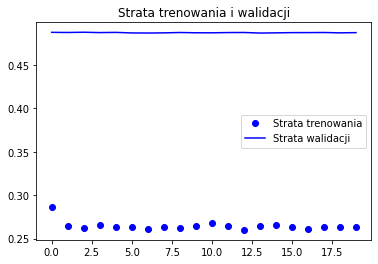

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Znacząco pokonaliśmy zdefiniowany wcześniej klasyfikator logiczny 0,7 będący naszym punktem odniesienia. Udowodniliśmy sensowność korzystania z uczenia maszynowego, a także wyższość w tego typu zadaniach sieci rekurencyjnych nad gęstymi sieciami spłaszczającymi sekwencje.

Uzyskaliśmy średnią bezwzględna wartość błędu na poziomie ~0,4 (zanim model zaczął ulegać znacznemu przeuczeniu), co odpowiada średniej pomyłce o 0,4 X 52,52 = 21PPM. To wyraźna poprawa względem uzyskanej wcześniej wartości 36 PPM.


PUNKT 7.3.2. GRU

In [43]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 33s 7ms/step - loss: nan - val_loss: nan
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 8/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 9/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 10/20
500/500 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 11/20
500/500 [==============================] - 3s 

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
# plt.title('Strata trenowania i walidacji')
# plt.legend()

# plt.show()

WNIOSKI: FUNKCJA STRATY DLA WALODACJI I TRENOWANIA JEST ZBLIZONA, NIE DOCHODZI DO ZBYTNIEGO PRZEUCZENIA

In [ ]:
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop

# model = Sequential()
# model.add(layers.GRU(32,
#                      dropout=0.2,
#                      recurrent_dropout=0.2,
#                      input_shape=(None, float_data.shape[-1])))
# model.add(layers.Dense(1))

# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#                               steps_per_epoch=500,
#                               epochs=40,
#                               validation_data=val_gen,
#                               validation_steps=val_steps)

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Strata trenowania')
# plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
# plt.title('Strata trenowania i walidacji')
# plt.legend()

# plt.show()